# Pirates EDA Notebook
### Ryan Corkrean

I first imported the necessary modules and configured the global environment. Then I used pandas to load the CSV file without any specifications.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator
from scipy.stats import norm

warnings.filterwarnings('ignore')

mdf = pd.read_csv('Fellow, Amateur Scouting - Data File 1.csv')
mdf.head()

,Player Information,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Pitcher Performance,Unnamed: 40,Unnamed: 41,Unnamed: 42,TrackMan Data,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,Scout,PlayerName,FutPos,RptPos,Height,Weight,Bat,Throw,Age,Level,...,ISO,BF,K%,BB%,ISO,BIP,AVG Exit Velo,Top End Exit Velo,Contact %,Chase %
1,1,Player01,CF,CF,74,190,L,L,18.392881,HS,...,0.198,NaN,NaN,NaN,NaN,36,80.9,90,0.74,0.25
2,7,Player02,CF,CF,72,186,L,R,20.859685,JC,...,0.115,NaN,NaN,NaN,NaN,52,71.9,93.1,0.66,0.28
3,9,Player03,LHS,LHS,74,205,R,L,19.080082,HS,...,NaN,234,0.112,0.092,0.104,NaN,NaN,NaN,NaN,NaN
4,8,Player04,CF,CF,75,195,L,L,21.316906,SO,...,0.193,NaN,NaN,NaN,NaN,182,84.6,100.7,0.74,0.36


I identified two header columns in the attached CSV file, so I reloaded the table with this additional parsing criterion.

In [35]:
mdf = pd.read_csv('Fellow, Amateur Scouting - Data File 1.csv', header=[0, 1])
h0 = mdf.columns.get_level_values(0)
h1 = mdf.columns.get_level_values(1)

mdf = mdf.set_axis(pd.MultiIndex.from_arrays([h0.to_series(index=range(mdf.shape[1])).mask(lambda x: x.str.startswith('Unnamed')).ffill(), h1]), axis=1)
mdf.head()

Player Information                                                   \
               Scout PlayerName FutPos RptPos Height Weight Bat Throw   
0                  1   Player01     CF     CF     74    190   L     L   
1                  7   Player02     CF     CF     72    186   L     R   
2                  9   Player03    LHS    LHS     74    205   R     L   
3                  8   Player04     CF     CF     75    195   L     L   
4                  7   Player05     3B     RF     77    187   L     R   

                    ... Hitter Performance Pitcher Performance                \
         Age Level  ...                ISO                  BF     K%    BB%   
0  18.392881    HS  ...              0.198                 NaN    NaN    NaN   
1  20.859685    JC  ...              0.115                 NaN    NaN    NaN   
2  19.080082    HS  ...                NaN               234.0  0.112  0.092   
3  21.316906    SO  ...              0.193                 NaN    NaN    NaN   
4  21.166324    SO  ...              0.156                 NaN    NaN    NaN   

         TrackMan Data                                                    
     ISO           BIP AVG Exit Velo Top End Exit Velo Contact % Chase %  
0    NaN          36.0          80.9              90.0      0.74    0.25  
1    NaN          52.0          71.9              93.1      0.66    0.28  
2  0.104           NaN           NaN               NaN       NaN     NaN  
3    NaN         182.0          84.6             100.7      0.74    0.36  
4    NaN          30.0          88.5             100.7      0.65    0.32  

[5 rows x 48 columns]

At this point, I noticed some inconsistencies in the data: the number of scouting grades in the Scouting Reports section of the dataset did not always sum to the value in the `RptCnt` field (perhaps some scouting grades went missing?).

In [36]:
mdf.loc[mdf['Report Information', 'RptCnt'] != mdf.loc[:, ('Report Information', [str(i) for i in range(1, 8)])].sum(axis=1), ('Report Information', ['RptCnt'] + [str(i) for i in range(1, 8)])]

Report Information                     
              RptCnt  1  2  3  4  5  6  7
4                  4  0  0  2  1  0  0  0
6                  7  0  0  1  4  1  0  0
9                  2  0  0  0  1  0  0  0

To enforce consistency between these fields, I redefined `RptCnt` to be the sum of the values in the corresponding scouting grade entries for future calculations. I also noticed that, while all of the players at four-year colleges were about the same age (21–22) all but one was listed as a sophomore. I assumed that this was a semantic, COVID-eligibility-related distinction, so I didn’t bother to change it.

I also dropped a few superfluous fields like `St` and `Date Seen` that didn’t give much additional context to that player’s profile. I used the `RptCnt` and scouting grades fields to derive scouting grade means and standard deviations/errors for each player.

In [0]:
mdf = mdf.drop(['St', 'Region', 'Date Seen'], axis=1, level=1)
mdf['Player Information', 'Level'] = mdf['Player Information', 'Level'].astype('category').cat.reorder_categories(['HS', 'JC', 'SO', 'JR', 'SR'], ordered=True)
mdf['Player Information', 'Height'] = mdf['Player Information', 'Height'].floordiv(12).astype(str) + "'" + mdf['Player Information', 'Height'].mod(12).astype(str) + '"'
mdf['Player Information', 'Age'] = mdf['Player Information', 'Age'].round(1)
mdf['Report Information', 'RptCnt'] = mdf.loc[:, ('Report Information', [str(i) for i in range(1, 8)])].sum(axis=1)
mdf.insert(
    loc=mdf.columns.get_loc(('Report Information', '7')) + 1,
    column=('Report Information', 'Grade'),
    value=(mdf.loc[:, ('Report Information', [str(i) for i in range(1, 8)])] * np.array([list(range(1, 8))] * mdf.shape[0])).sum(axis=1).div(mdf['Report Information', 'RptCnt']).round(1).tolist()
)
mdf.insert(
    loc=mdf.columns.get_loc(('Report Information', 'Grade')) + 1,
    column=('Report Information', 'GradeSE'),
    value=(mdf.loc[:, ('Report Information', [str(i) for i in range(1, 8)])] * (np.array([list(range(1, 8))] * mdf.shape[0]) - mdf['Report Information', 'Grade'].to_numpy().reshape(-1, 1)) ** 2).sum(axis=1).pow(0.5).div(mdf['Report Information', 'RptCnt'] - np.where(mdf['Report Information', 'RptCnt'] == 1, 0, 1)).round(1)
)
mdf = mdf.drop(('Report Information', 'RptCnt'), axis=1).sort_values(('Player Information', 'Level'), ascending=False)

Finally, I ordered the dataset by level of play and split it into two tables (one for hitters, one for pitchers).

In [37]:
bat = mdf[~mdf['Player Information', 'FutPos'].isin(['LHS', 'LHR', 'RHS', 'RHR'])].dropna(axis=1).drop('Pitcher Scouting Reports', axis=1).reset_index(drop=True)
bat['Position Player Reports'] = bat['Position Player Reports'].astype(int)
bat[[('Hitter Performance', 'PA'), ('TrackMan Data', 'BIP')]] = bat[[('Hitter Performance', 'PA'), ('TrackMan Data', 'BIP')]].astype(int)
pit = mdf[mdf['Player Information', 'FutPos'].isin(['LHS', 'LHR', 'RHS', 'RHR'])].dropna(axis=1).drop('Position Player Reports', axis=1).reset_index(drop=True)
pit['Pitcher Scouting Reports'] = pit['Pitcher Scouting Reports'].astype(int)
pit['Pitcher Performance', 'BF'] = pit['Pitcher Performance', 'BF'].astype(int)

bat

Player Information                                                         \
                Scout PlayerName FutPos RptPos Height Weight Bat Throw   Age   
0                   3   Player15     1B     1B   6'4"    225   R     R  21.3   
1                   1   Player11     2B     2B  5'11"    180   R     R  21.2   
2                   8   Player04     CF     CF   6'3"    195   L     L  21.3   
3                   7   Player05     3B     RF   6'5"    187   L     R  21.2   
4                   5   Player06     CF     CF   6'0"    210   L     R  21.9   
5                   9   Player07     CF     CF   6'0"    175   L     L  21.1   
6                   7   Player02     CF     CF   6'0"    186   L     R  20.9   
7                   2   Player19     3B     3B   6'1"    188   R     R  18.0   
8                   2   Player18      C      C  5'11"    200   R     R  18.4   
9                   1   Player01     CF     CF   6'2"    190   L     L  18.4   
10                  3   Player14      C      C   6'3"    210   R     R  18.9   
11                  4   Player13     RF     RF  5'11"    220   L     L  18.2   

          ... Position Player Reports Hitter Performance                       \
   Level  ...                   FIELD                 PA     K%    BB%    ISO   
0     SR  ...                      46                432  0.211  0.091  0.102   
1     SO  ...                      52                444  0.180  0.099  0.172   
2     SO  ...                      51                359  0.150  0.108  0.193   
3     SO  ...                      50                150  0.206  0.097  0.156   
4     SO  ...                      58                473  0.230  0.126  0.123   
5     SO  ...                      53                539  0.161  0.089  0.132   
6     JC  ...                      58                179  0.235  0.111  0.115   
7     HS  ...                      50                221  0.302  0.093  0.103   
8     HS  ...                      51                582  0.063  0.013  0.100   
9     HS  ...                      55                304  0.278  0.072  0.198   
10    HS  ...                      50                492  0.281  0.106  0.153   
11    HS  ...                      48                328  0.178  0.083  0.110   

   TrackMan Data                                                    
             BIP AVG Exit Velo Top End Exit Velo Contact % Chase %  
0             35          85.6              99.4      0.69    0.35  
1            156          81.0              99.3      0.79    0.34  
2            182          84.6             100.7      0.74    0.36  
3             30          88.5             100.7      0.65    0.32  
4            135          81.5              99.1      0.71    0.23  
5            237          82.1              95.9      0.79    0.42  
6             52          71.9              93.1      0.66    0.28  
7             33          74.2              84.7      0.74    0.27  
8              4          73.6              73.6      0.53    0.56  
9             36          80.9              90.0      0.74    0.25  
10            34          82.6              87.5      0.75    0.27  
11            41          82.8              96.0      0.68    0.33  

[12 rows x 35 columns]

In [38]:
pit

Player Information                                                         \
               Scout PlayerName FutPos RptPos Height Weight Bat Throw   Age   
0                  2   Player16    LHS    LHS   6'2"    176   L     L  21.5   
1                  4   Player10    RHS    RHS   6'4"    205   L     R  21.6   
2                  2   Player17    RHR    RHR   6'3"    205   R     R  21.5   
3                  6   Player09    RHS    RHS   6'3"    190   R     R  21.1   
4                  5   Player12    RHS    RHS   6'6"    235   R     R  21.2   
5                  3   Player08    RHS    RHS   6'2"    205   R     R  19.1   
6                  9   Player03    LHS    LHS   6'2"    205   R     L  19.1   
7                  4   Player20    LHS    LHS   6'3"    190   L     L  18.8   

         ... Report Information Pitcher Scouting Reports                       \
  Level  ...            GradeSE                  ATHLETE FB Velo FB Grade  CV   
0    JR  ...                0.0                       52      92       52  45   
1    JR  ...                0.0                       47      93       57  52   
2    JR  ...                0.0                       50      98       60  50   
3    SO  ...                0.2                       52      92       55  47   
4    SO  ...                0.7                       50      94       54  50   
5    JC  ...                0.5                       51      92       55  47   
6    HS  ...                1.4                       52      92       50  50   
7    HS  ...                0.1                       50      92       53  50   

          Pitcher Performance                       
  CONTROL                  BF     K%    BB%    ISO  
0      50                 262  0.232  0.164  0.088  
1      57                 218  0.328  0.119  0.099  
2      40                  23  0.462  0.068  0.102  
3      53                 458  0.223  0.095  0.106  
4      45                 103  0.067  0.093  0.072  
5      53                 401  0.256  0.121  0.134  
6      55                 234  0.112  0.092  0.104  
7      55                 333  0.098  0.198  0.092  

[8 rows x 29 columns]

I generated reports/figures for hitters first.

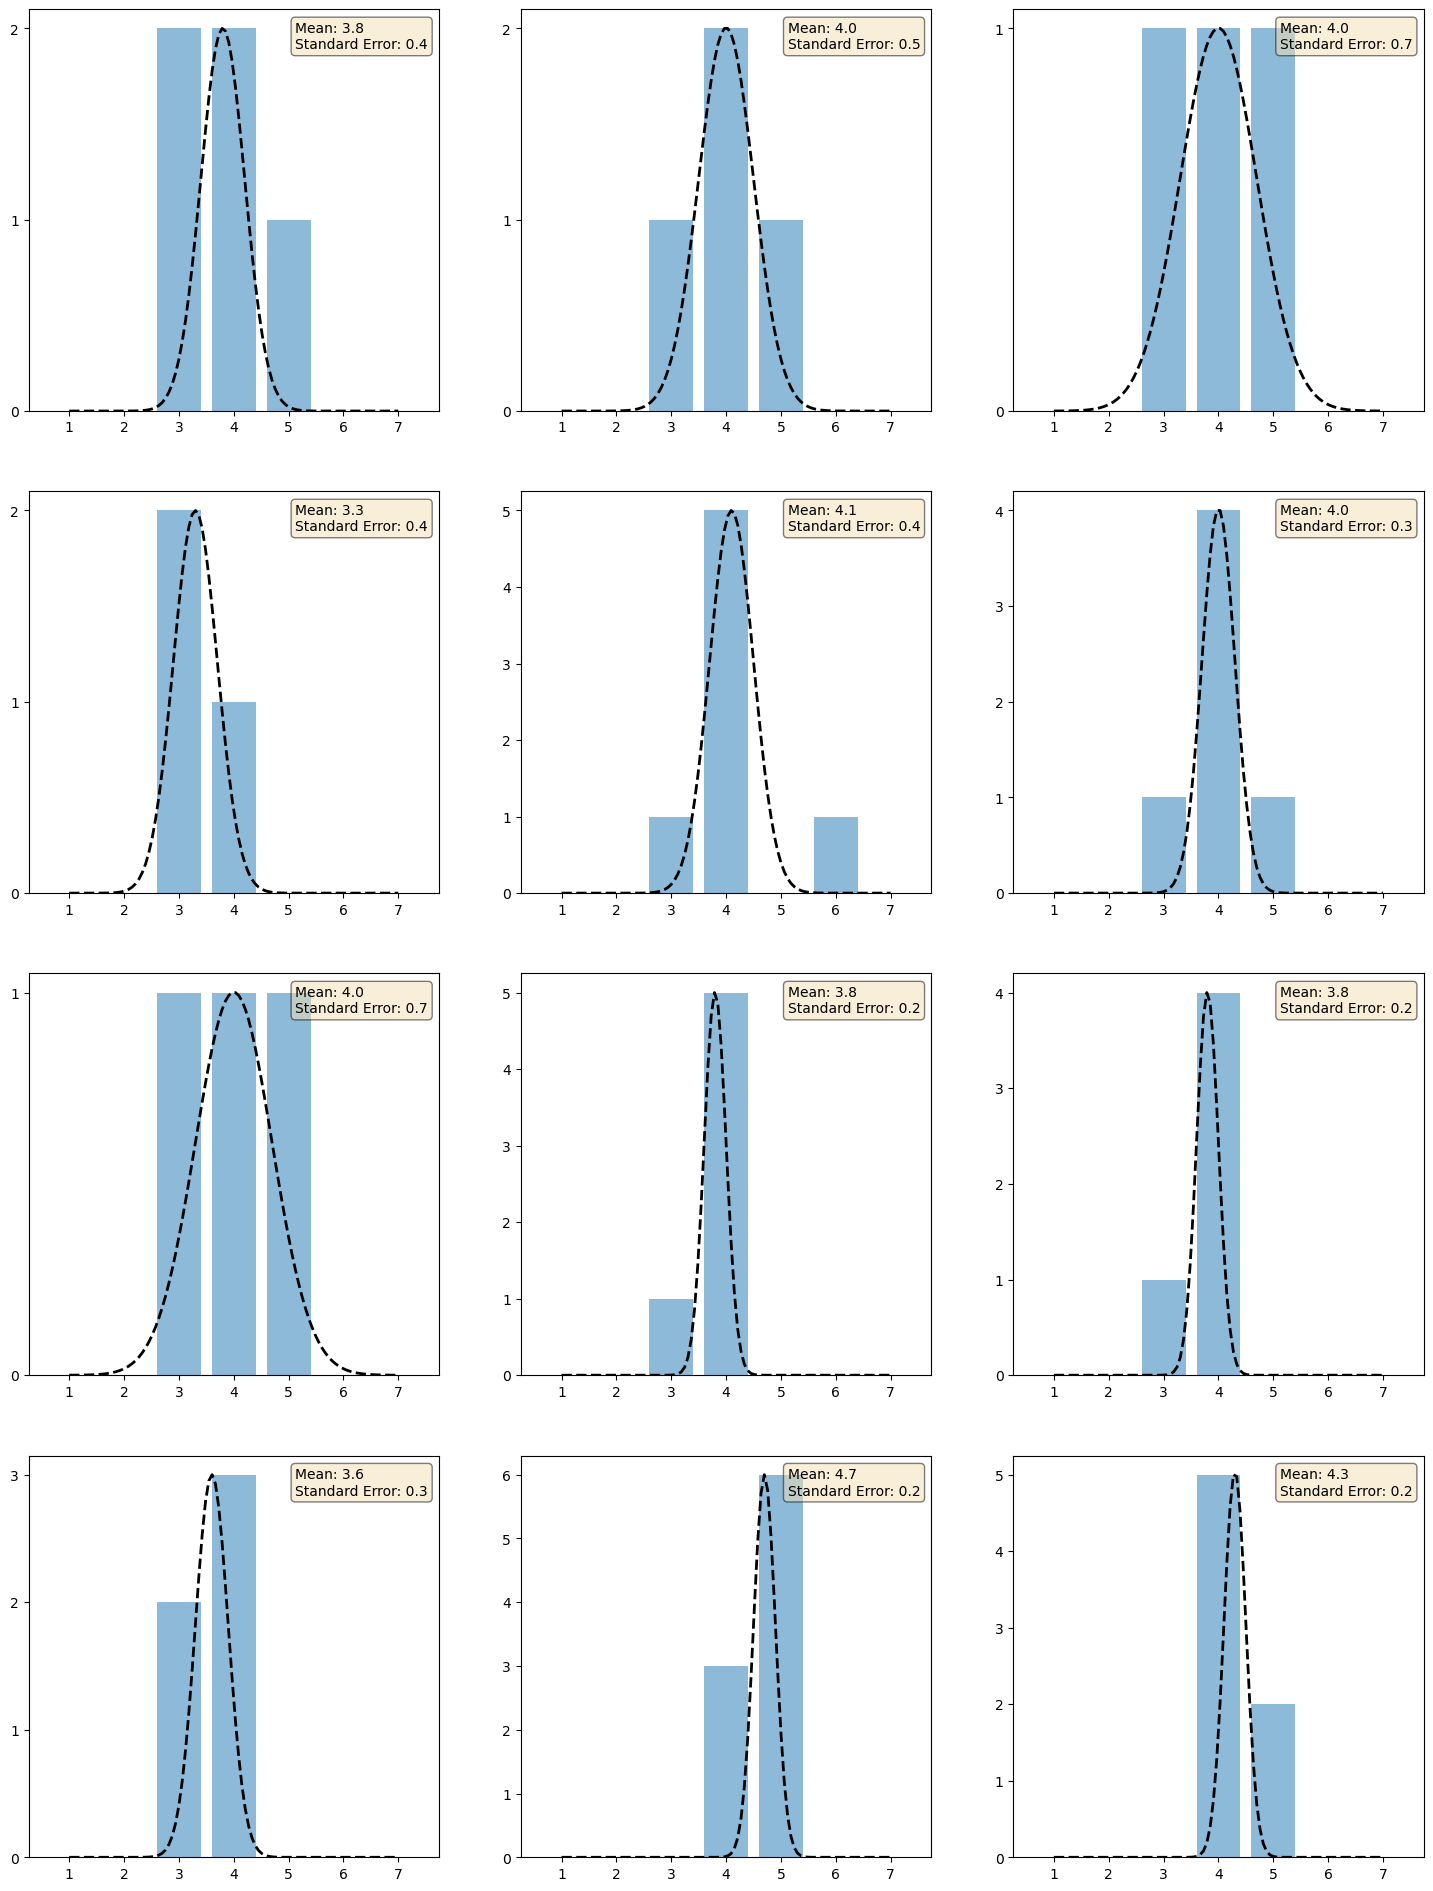

In [103]:
fig, ax = plt.subplots(4, 3, figsize=(18.0, 24.0))

for i, data in bat['Report Information'].iterrows():
    ax[i // 3, i % 3].bar(x=np.arange(1, 8), height=data.loc['1': '7'], alpha=0.5)
    ax[i // 3, i % 3].plot(np.linspace(1, 7, 100), norm.pdf(np.linspace(1, 7, 100), data.loc['Grade'], data.loc['GradeSE']) * data.loc['1': '7'].max() / norm.pdf(np.linspace(1, 7, 100), data.loc['Grade'], data.loc['GradeSE']).max(), color='black', linestyle='dashed', linewidth=2.0)
    ax[i // 3, i % 3].text(0.65, 0.97, f'Mean: {data.loc['Grade']}\nStandard Error: {data.loc['GradeSE']}', fontsize=10.0, transform=ax[i // 3, i % 3].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[i // 3, i % 3].set_xticks(range(1, 8))
    ax[i // 3, i % 3].yaxis.set_major_locator(MaxNLocator(integer=True))
    
plt.show()

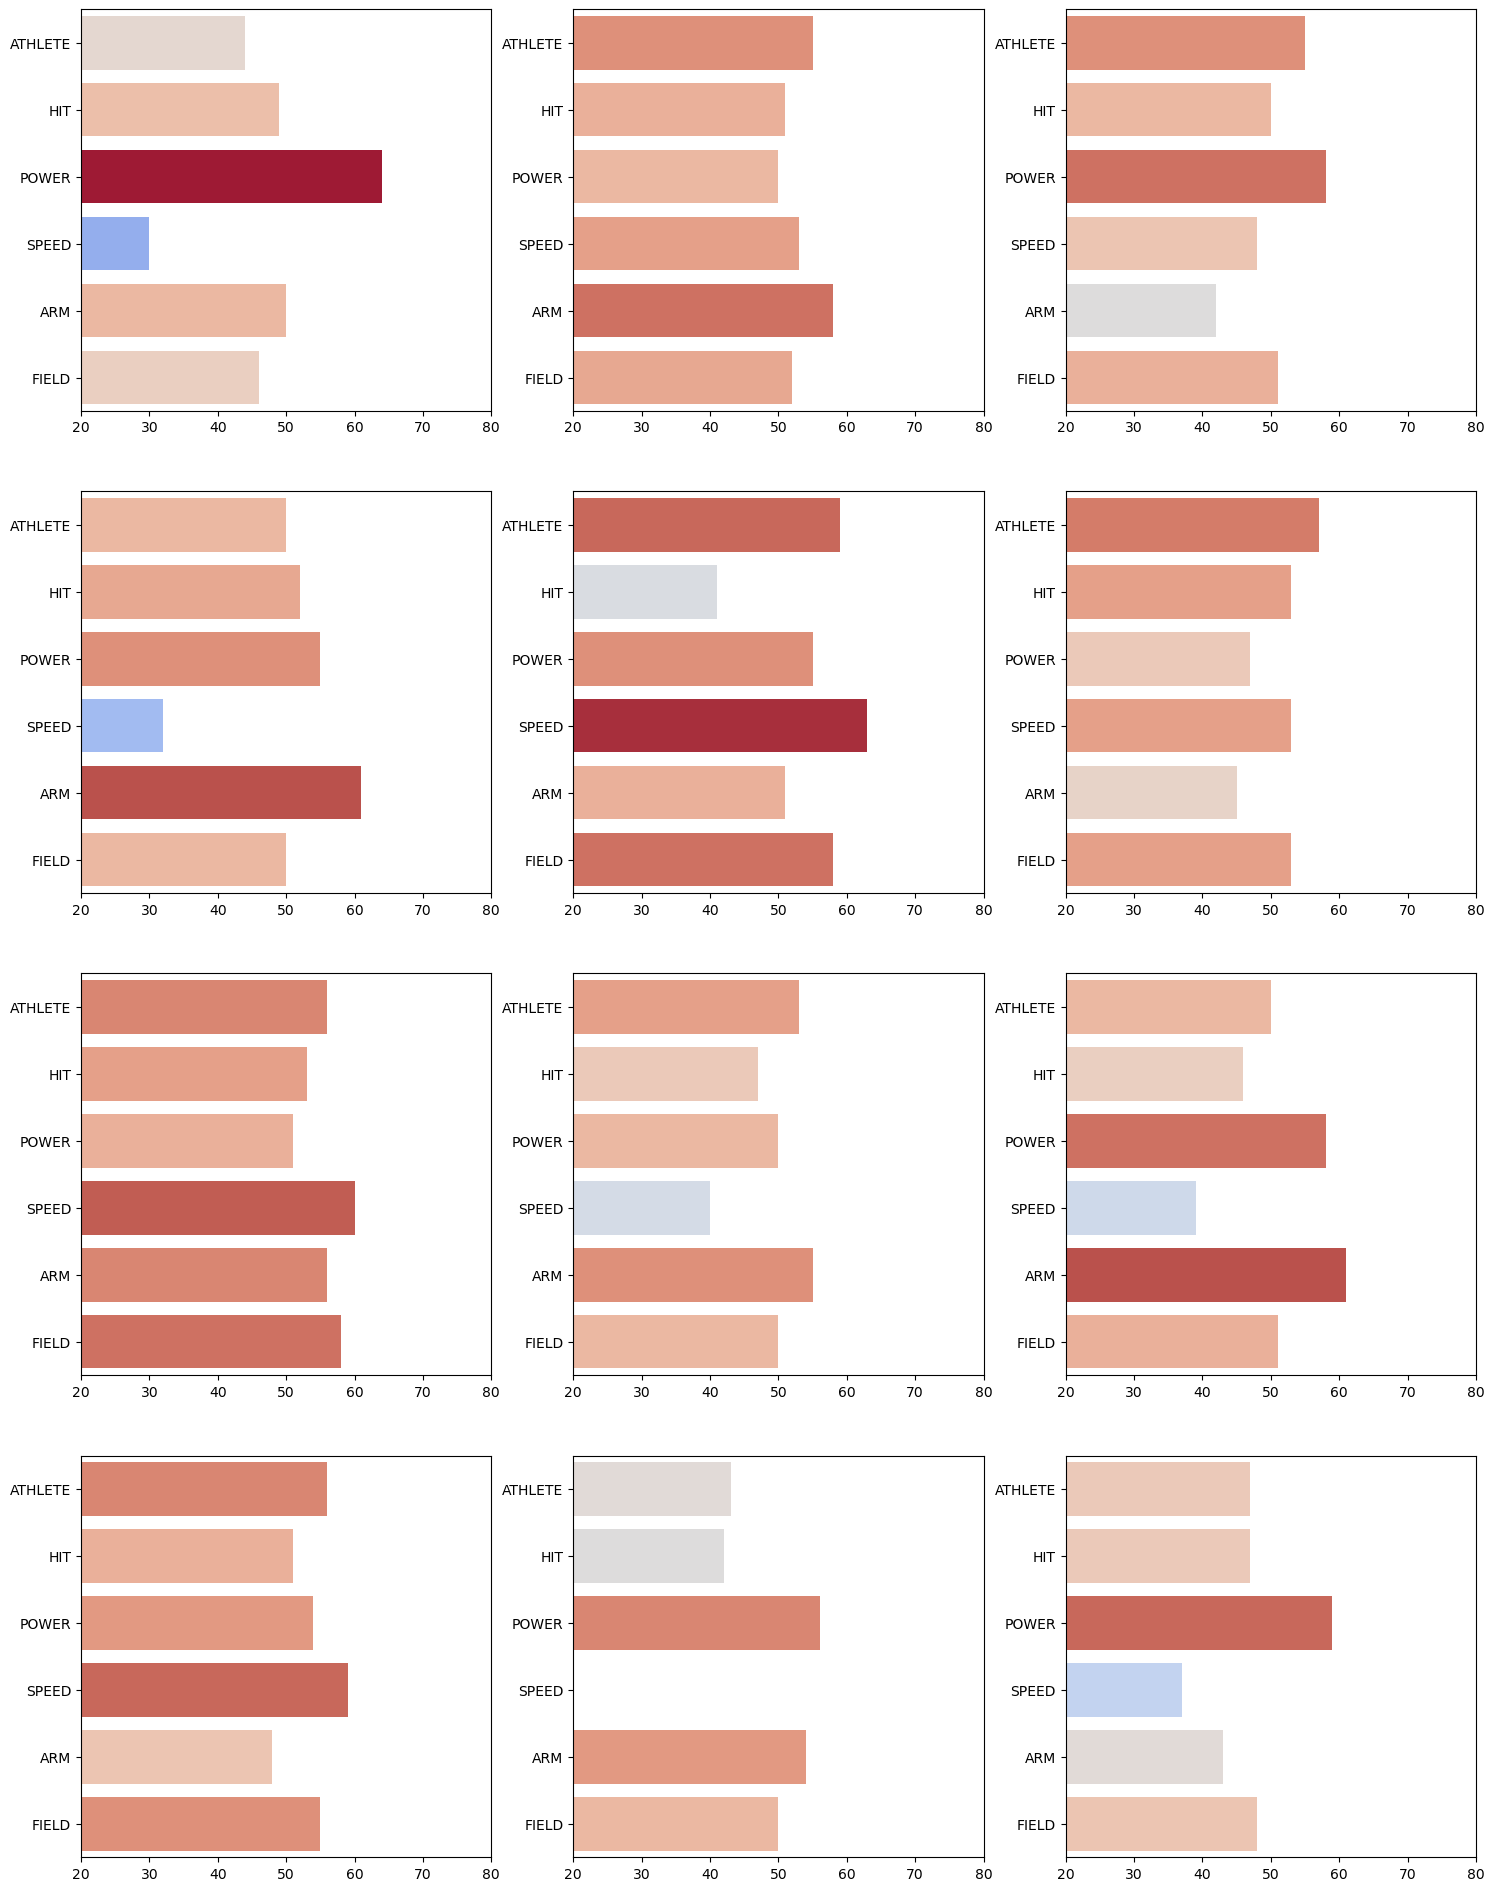

In [93]:
fig, ax = plt.subplots(4, 3, figsize=(18.0, 24.0))
scale_min, scale_max = bat['Position Player Reports'].min(axis=None), bat['Position Player Reports'].max(axis=None)

for i, data in bat['Position Player Reports'].iterrows():
    sns.barplot(x=data.to_numpy(), y=data.index, hue=data.to_numpy(), palette='coolwarm', hue_norm=(scale_min, scale_max), legend=False, ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_ylabel(None)
    ax[i // 3, i % 3].set_xlim(20, 80)
    
plt.show()

I then tackled pitchers in a similar fashion.

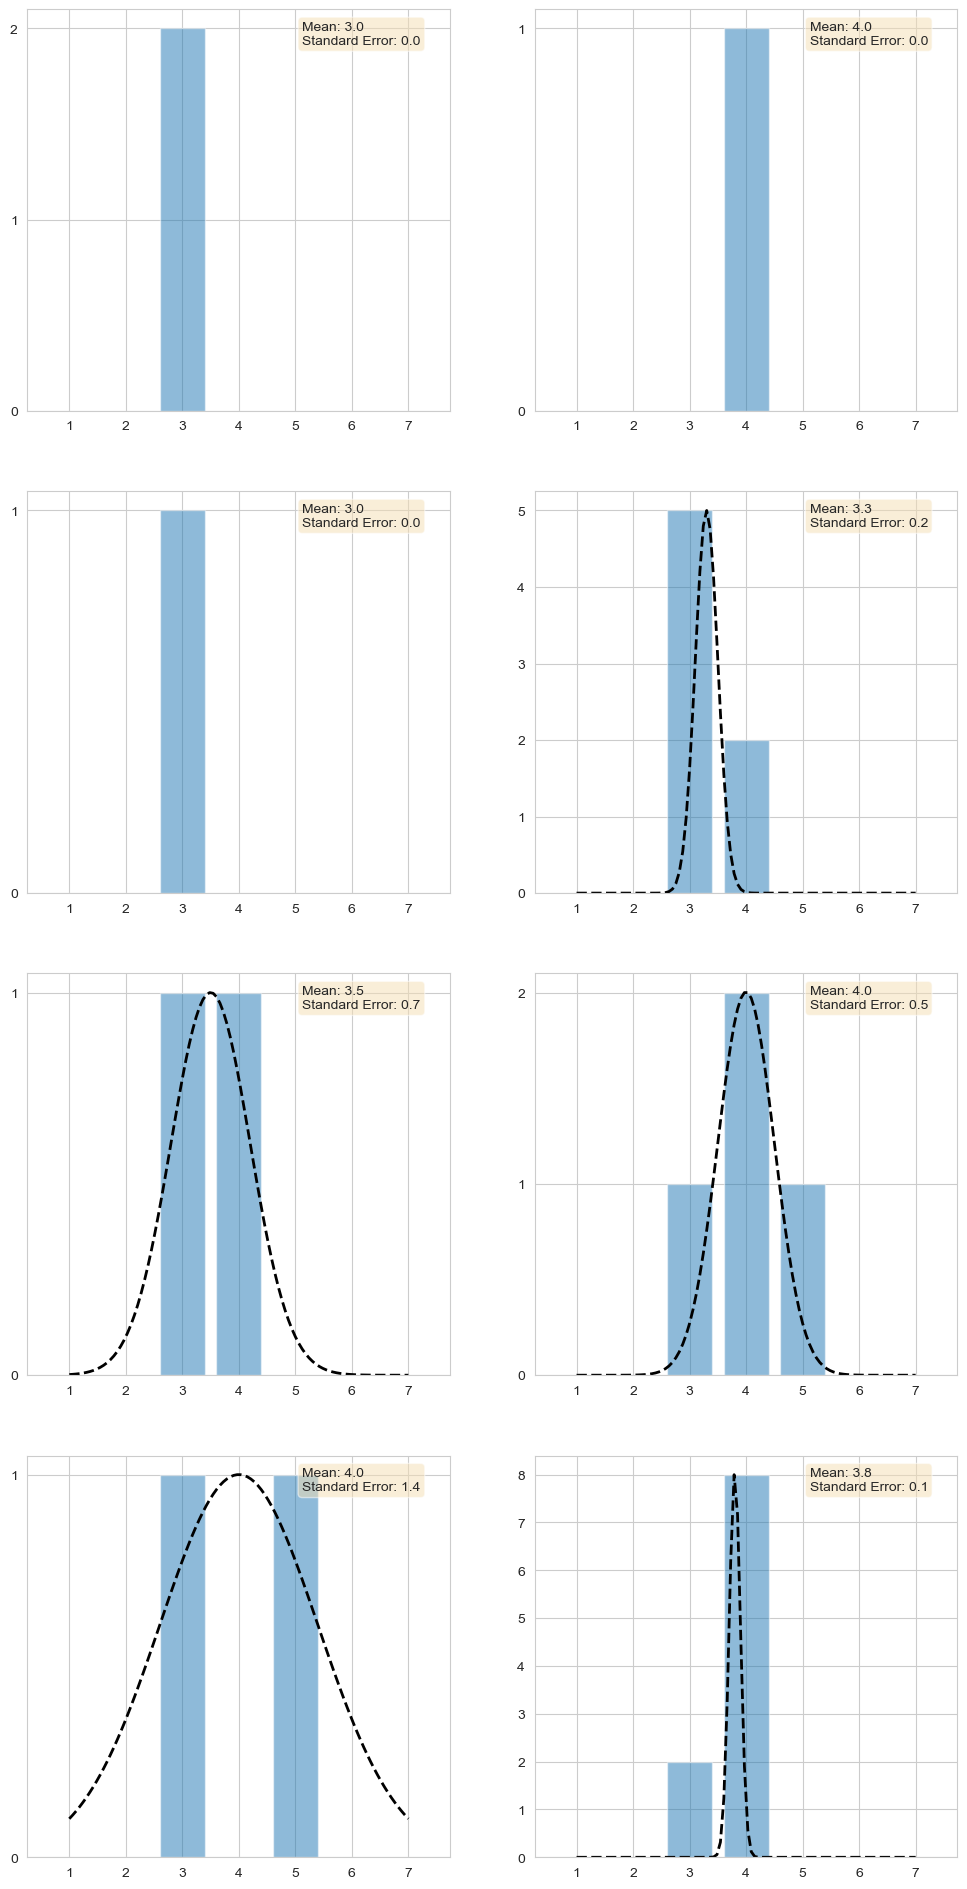

In [40]:
fig, ax = plt.subplots(4, 2, figsize=(12.0, 24.0))

for i, data in pit['Report Information'].iterrows():
    ax[i // 2, i % 2].bar(x=np.arange(1, 8), height=data.loc['1': '7'], alpha=0.5)
    ax[i // 2, i % 2].plot(np.linspace(1, 7, 100), norm.pdf(np.linspace(1, 7, 100), data.loc['Grade'], data.loc['GradeSE']) * data.loc['1': '7'].max() / norm.pdf(np.linspace(1, 7, 100), data.loc['Grade'], data.loc['GradeSE']).max(), color='black', linestyle='dashed', linewidth=2.0)
    ax[i // 2, i % 2].text(0.65, 0.97, f'Mean: {data.loc['Grade']}\nStandard Error: {data.loc['GradeSE']}', fontsize=10.0, transform=ax[i // 2, i % 2].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[i // 2, i % 2].set_xticks(range(1, 8))
    ax[i // 2, i % 2].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

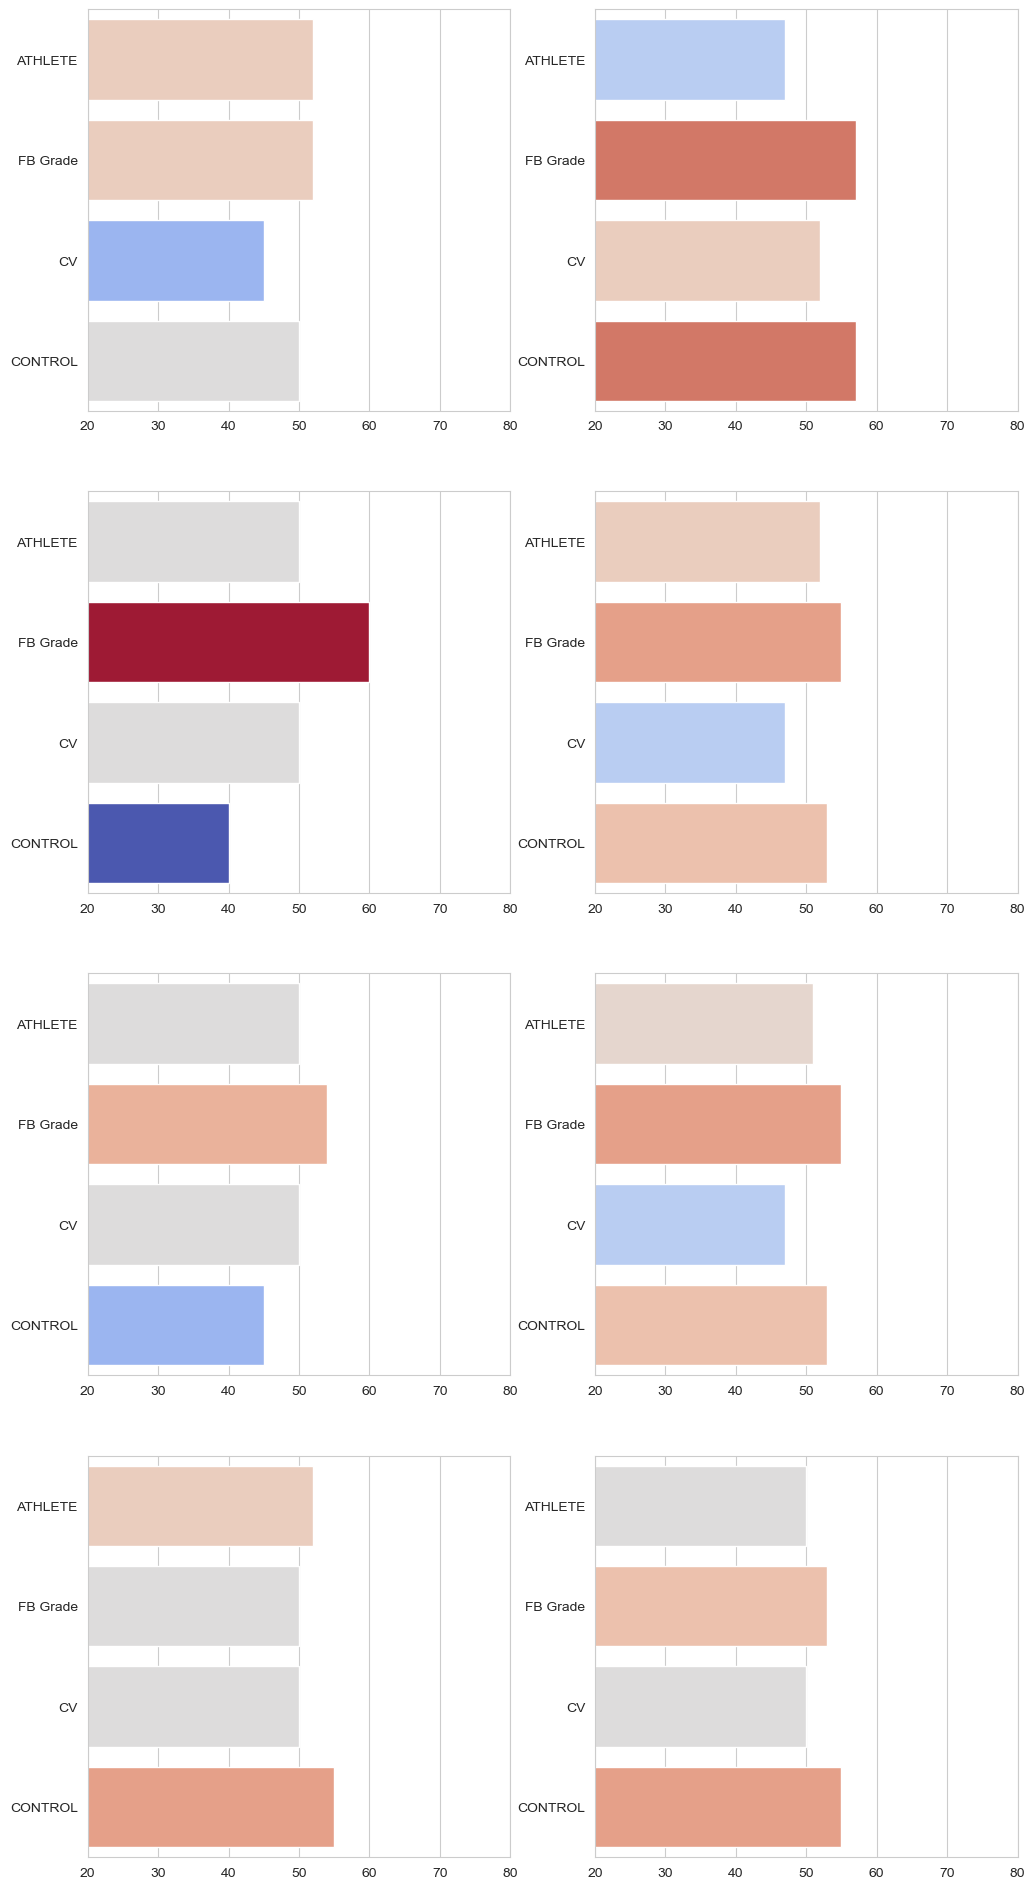

In [62]:
fig, ax = plt.subplots(4, 2, figsize=(12.0, 24.0))
scale_min, scale_max = pit.loc[:, ('Pitcher Scouting Reports', ['ATHLETE', 'FB Grade', 'CV', 'CONTROL'])].min(axis=None), pit.loc[:, ('Pitcher Scouting Reports', ['ATHLETE', 'FB Grade', 'CV', 'CONTROL'])].max(axis=None)

for i, data in pit.loc[:, ('Pitcher Scouting Reports', ['ATHLETE', 'FB Grade', 'CV', 'CONTROL'])].reset_index(level=0, drop=True).iterrows():
    sns.barplot(x=data.to_numpy(), y=data.index.get_level_values(1), hue=data.to_numpy(), palette='coolwarm', hue_norm=(scale_min, scale_max), legend=False, ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_ylabel(None)
    ax[i // 2, i % 2].set_xlim(20, 80)

plt.show()